# Libraries

In [8]:
!pip install svgwrite


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [176]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

import sys, os
py_file_location = "/content/gdrive/My Drive/AML6/"
sys.path.append(os.path.abspath(py_file_location))

Mounted at /content/gdrive/


In [9]:
import svgwrite
from IPython.display import display, SVG
import numpy as np
import random
import seaborn as sns

# Drawing function

In [10]:
palette = sns.color_palette('viridis', 101)
palette = [(int(p[0]*255),int(p[1]*255),int(p[2]*255)) for p in palette]

def draw(im, show=True, unit=10, depart=(0,0), goal=(29,9), paths=None, title='default.svg'):

    im = im*1.
    padding = 1.5 * unit
    size_x = (2*padding) + im.shape[0]*unit
    size_y = (2*padding) + im.shape[1]*unit
    dwg = svgwrite.Drawing(py_file_location+'_svg/'+title, size=(size_x, size_y))

    for i in range(im.shape[0]):
        for ii in range(im.shape[1]):

            g = int(im[i,ii])
            rgb = palette[g]
            color = svgwrite.rgb(*rgb)
            x, y = padding + (i*unit), padding + (ii*unit)
            tile = dwg.rect(insert=(x,y), size=(unit,unit)).fill(color)
            dwg.add(tile)

    agent_color = svgwrite.rgb(255, 0, 0)
    stroke = 2.
    t_unit = unit - stroke
    t_size = 3.

    if paths is not None:
        for path in paths:
          points = [(padding + (coo[0] * unit) + (0.5 * unit), padding + (coo[1] * unit) + (0.5 * unit)) for coo in path]
          #path = dwg.polyline(points=points, fill="none").stroke(color="white", width=stroke*3)
          #dwg.add(path)
          path = dwg.polyline(points=points, fill="none").stroke(color=agent_color, width=stroke)
          dwg.add(path)

    # departure and goal
    dpt_x, dpt_y = (unit * 0.5) + padding + depart[0] * unit, (unit * 0.5) + padding + depart[1] * unit
    dpt = dwg.circle(center=(dpt_x,dpt_y), r=t_unit*(t_size*0.8)).fill(agent_color).stroke(color="white", width=stroke)
    dwg.add(dpt)

    arr_x, arr_y = (unit * 0.5) + padding + goal[0] * unit, (unit * 0.5) + padding + goal[1] * unit
    pt1 = (arr_x + np.sin(np.deg2rad(60)) * t_unit * t_size, arr_y + np.cos(np.deg2rad(60)) * t_unit * t_size)
    pt2 = (arr_x, arr_y - (t_unit * t_size))
    pt3 = (arr_x - np.sin(np.deg2rad(60)) * t_unit * t_size, arr_y + np.cos(np.deg2rad(60)) * t_unit * t_size)
    points = [pt1, pt2, pt3]
    arrival = dwg.polygon(points=points).stroke(color="white", width=stroke).fill(agent_color)
    dwg.add(arrival)

    if show: display(SVG(dwg.tostring()))
    return dwg


# Data

In [11]:
py_file_location = ''
import numpy as np
import json
with open(py_file_location+'data.json', 'r') as f:
    XYZ = np.array(json.load(f))

# Model

In [12]:
M, N = XYZ.shape
print (M, N)
XYZ[:5,:5]

140 100


array([[1.75281993, 2.20349821, 0.39252358, 0.15336861, 0.71133869],
       [0.58090414, 0.47255528, 0.04671693, 0.43491874, 0.22772565],
       [0.08492156, 0.        , 0.22637886, 1.78536252, 2.23335983],
       [1.44392988, 2.08848844, 1.56313176, 0.36974565, 2.09144632],
       [2.92843099, 3.0257302 , 1.89053942, 0.32816689, 1.72886461]])

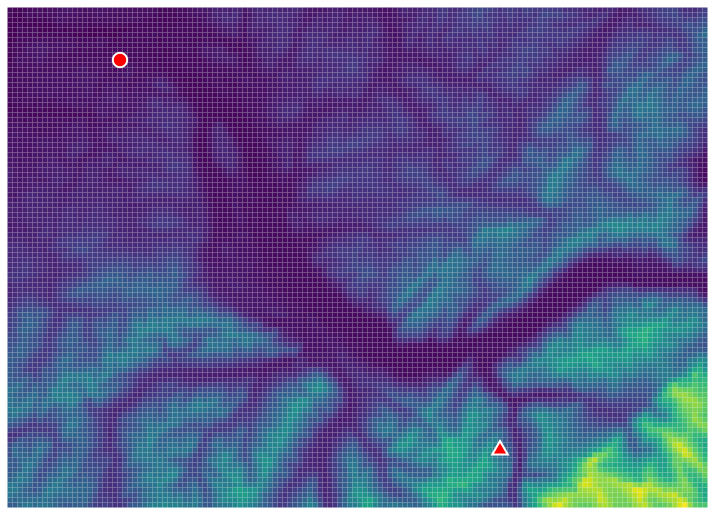

In [15]:
start_pos = (22, 10) # Bern
end_pos =   (98, 88) # Mürren
dwg = draw (XYZ, depart=start_pos, goal=end_pos, unit=5, title="map.svg")
dwg.save()

In [19]:
# Define the environment
grid_size = (M, N)
rewards = XYZ
start_pos = (22, 10) # Bern
end_pos =   (98, 88) # Mürren

# Define actions
actions = ['ur', 'ul', 'dr', 'dl']
action_to_index = {action: i for i, action in enumerate(actions)}

# Q-table initialization
Q_table = np.zeros((M, N, len(actions)))

# Hyperparameters
alpha = 0.005           # Learning rate
gamma = 0.9             # Discount factor
epsilon = 0.99          # Exploration rate
max_steps = 250         # Maximum steps per episode
num_episodes = 100000   # Number of episodes for training

# Function to get the next state based on the current state and action
def get_next_state(state, action):
    x, y = state
    if action == 'ur': x -= 1; y += 1
    elif action == 'ul': x -= 1; y -= 1
    elif action == 'dr': x += 1; y += 1
    elif action == 'dl': x += 1; y -= 1
    return x, y

# Training the agent
scores = []
previous_reached = 0
reached = 0
last_z = 0

for episode in range(num_episodes):

    #state = (random.choice(range(int(M/2.)))*2, random.choice(range(int(N/2.)))*2) # random state for generalization
    state = start_pos
    path = [state]
    total_reward = 0

    for step in range(max_steps):
        x, y = state

        # Choose action: epsilon-greedy strategy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Explore
        else:
            action = actions[np.argmin(Q_table[x, y])]  # Exploit

        # Get next state
        next_state = get_next_state(state, action)
        path.append(next_state)
        nx, ny = next_state

        # Check if next state is out of bounds
        if nx < 0 or nx >= grid_size[0] or ny < 0 or ny >= grid_size[1]:
            reward = 10000
            total_reward += reward
            Q_table[x, y, action_to_index[action]] += alpha * (reward - Q_table[x, y, action_to_index[action]])
            break

        else:
            distance = ((nx-end_pos[0])**2 + (ny-end_pos[1])**2) ** 0.5
            reward = distance + (rewards[nx, ny] * distance * 1e-1)
            total_reward += reward

            Q_table[x, y, action_to_index[action]] += alpha * (
                reward + gamma * np.min(Q_table[nx, ny]) - Q_table[x, y, action_to_index[action]]
            )

            state = next_state

            if state == end_pos:
                reached += 1
                break

    scores.append(total_reward)

    if episode%100==0:
        #dwg = draw(R, depart=start_pos, goal=end_pos, unit=5, path=path, show=False, title=f"{int(episode/100.):05d}.svg")
        #dwg.save()
        pass

    if episode%5000==0:
        print (f"Episode {episode: 7d}, score {total_reward: 10.1f}, reached {reached - previous_reached: 5d}")
        previous_reached = reached

    # Optionally, decay epsilon to reduce exploration over time
    epsilon = max(0.1, epsilon * 0.999)

print ("total reached", reached)

Episode       0, score    39117.3, reached     0
Episode    5000, score    42235.1, reached     0
Episode   10000, score    33077.6, reached     0
Episode   15000, score    41436.9, reached     0
Episode   20000, score    35971.7, reached     0
Episode   25000, score    46337.8, reached     0
Episode   30000, score    29055.9, reached     0
Episode   35000, score    27573.2, reached     0
Episode   40000, score    42731.4, reached     0
Episode   45000, score    21425.7, reached     0
Episode   50000, score    51233.6, reached     0
Episode   55000, score    41433.3, reached     0
Episode   60000, score    29416.3, reached     8
Episode   65000, score    21236.5, reached    38
Episode   70000, score    15141.8, reached   151
Episode   75000, score    43563.4, reached   511
Episode   80000, score    11136.3, reached  1198
Episode   85000, score    14920.1, reached  2084
Episode   90000, score    10850.8, reached  2902
Episode   95000, score    10119.0, reached  3673
total reached 14770


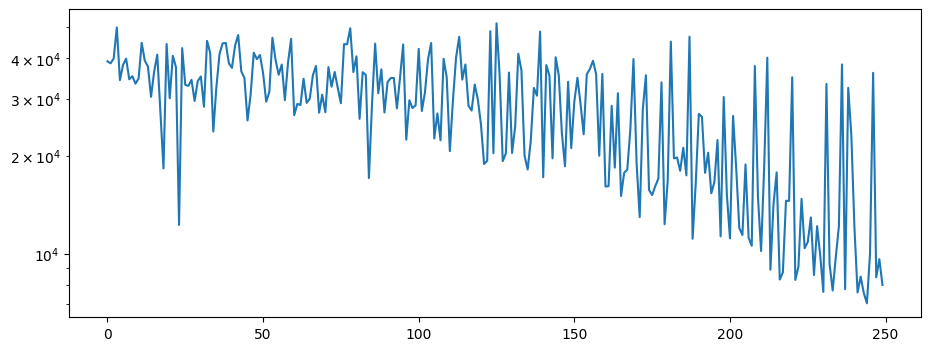

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(11,4))
plt.yscale('log')
_ = plt.plot(scores[::400])

In [23]:
# Function to extract the optimal policy from the Q-table
def get_optimal_policy(Q_table):
    grid_size = Q_table.shape
    policy = np.full(grid_size[:2], '', dtype=object)

    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            # Choose the action with the minimum Q-value for each state
            best_action_index = np.argmin(Q_table[x, y])
            policy[x, y] = actions[best_action_index]

    return policy

# Function to simulate a run using the optimal policy
def simulate_policy(policy, start_state=start_pos, end_state=end_pos):

    state = start_state
    path = [state]
    total_reward = 0
    steps = 0
    last_z = 0

    while state != end_state and steps < max_steps:  # Stop if goal is reached or max steps exceeded
        x, y = state
        action = policy[x, y]
        next_state = get_next_state(state, action)

        # Check for out-of-bounds
        nx, ny = next_state
        if nx < 0 or nx >= grid_size[0] or ny < 0 or ny >= grid_size[1]:
            total_reward += 10000  # Out-of-bounds penalty
            break

        # Add reward for the next state
        z = rewards[nx, ny]
        delta = abs(z - last_z)
        reward = delta
        total_reward += reward
        last_z = z

        state = next_state
        path.append(state)
        steps += 1

    return path, total_reward

In [24]:
# Derive the optimal policy
optimal_policy = get_optimal_policy(Q_table)

# Visualize the optimal policy
print("Optimal Policy :")
print (optimal_policy[0])
print ('...')

with open(py_file_location+'Q_table.json', 'w') as f:
  json.dump(Q_table.tolist(), f)

Optimal Policy :
['dr' 'ur' 'dr' 'ur' 'dl' 'ur' 'dr' 'ur' 'dr' 'ur' 'dr' 'ur' 'dl' 'ur'
 'dr' 'ur' 'dl' 'ur' 'dr' 'ur' 'dl' 'ur' 'dr' 'ur' 'dr' 'ur' 'dl' 'ur'
 'dl' 'ur' 'dl' 'ur' 'dr' 'ur' 'dl' 'ur' 'dr' 'ur' 'dr' 'ur' 'dr' 'ur'
 'dr' 'ur' 'dl' 'ur' 'dr' 'ur' 'dr' 'ur' 'dr' 'ur' 'dr' 'ur' 'dr' 'ur'
 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dr' 'ur' 'dl' 'ur'
 'dl' 'ur' 'dr' 'ur' 'dr' 'ur' 'ul' 'ur' 'ul' 'ur' 'ul' 'ur' 'ul' 'ur'
 'ul' 'ur' 'ul' 'ur' 'ul' 'ur' 'ul' 'ur' 'ur' 'ur' 'ul' 'ur' 'ul' 'ur'
 'ul' 'ur']
...


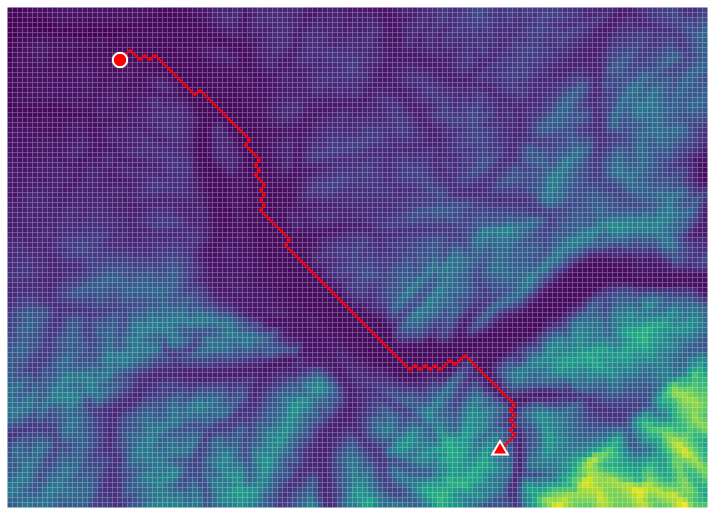

In [26]:
# Bern to Mürren

path, _ = simulate_policy(optimal_policy, start_state=start_pos, end_state=end_pos)
dwg = draw (XYZ, depart=start_pos, goal=end_pos, unit=5, paths=[path], title="bern_muerren.svg")
dwg.save()

In [ ]:
# (almost) all roads lead to Mürren

print (len(R0.ravel()))

start_pos_list = []
for i in range(len(R0.ravel())):
  x = i%140
  y = i//140
  if x%2!=0 or y%2!=0: continue
  start_pos_list.append((x,y))

paths = []
for pos in start_pos_list:
  path, _ = simulate_policy(optimal_policy, start_state=pos, end_state=end_pos)
  paths.append(path)

dwg = draw (R, depart=start_pos, goal=end_pos, unit=5, paths=paths, title="all_roads.svg")
dwg.save()

In [ ]:
# Show that the best policy path is not necessarily the local minimum
# the model has a larger knowledge of the terrain

# Javascript

In [ ]:
print (paths[1500])

[(60, 42), (59, 43), (60, 44), (59, 45), (58, 46), (57, 47), (56, 48), (57, 49), (58, 50), (59, 51), (60, 52), (61, 53), (62, 54), (63, 55), (64, 56), (65, 57), (66, 58), (67, 59), (68, 60), (69, 61), (70, 62), (71, 63), (72, 64), (73, 65), (74, 66), (75, 67), (76, 68), (77, 69), (78, 70), (79, 71), (80, 72), (81, 73), (82, 72), (83, 71), (84, 72), (85, 71), (86, 72), (87, 71), (88, 70), (89, 71), (90, 70), (91, 69), (92, 70), (93, 71), (94, 72), (95, 73), (96, 74), (97, 75), (98, 76), (99, 77), (100, 78), (101, 79), (100, 80), (101, 81), (100, 82), (101, 83), (100, 84), (101, 85), (100, 86), (99, 87), (98, 88)]


In [ ]:
spaths = []

scale = 5
for path in paths:
  s = ""
  for coo in path:
    a, b = coo
    s += str(a*scale)+','+str(b*scale)+' '
  spaths.append(s)

print (len(spaths))
print (spaths)

Output hidden; open in https://colab.research.google.com to view.